<a href="https://colab.research.google.com/github/nirmal129/Qalculator/blob/master/Qalculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations, imports, and helper functions



In [ ]:
%pip install qiskit --quiet
%pip install pylatexenc --quiet

In [ ]:
from qiskit import *
import numpy as np
from qiskit.visualization import *
from qiskit.quantum_info import *
from matplotlib import pyplot as plt

In [ ]:
# CCU1 or CCRz

def ccu1(qc, theta, a, b, c):
  qc.cu1(theta / 2, b, c)
  qc.cx(a, b)
  qc.cu1(-theta / 2, b, c)
  qc.cx(a, b)
  qc.cu1(theta / 2, a, c)

In [ ]:
# QFT

def qft(qc, q):
  n = len(q)
  for j in range(n - 1, -1, -1):
    qc.h(q[j])
    for k in range(j - 1, -1, -1):
      qc.cu1(2 * np.pi * 2 ** (-(j - k + 1)), q[k], q[j])
  for l in range(int(np.floor(n / 2))):
    qc.swap(q[l], q[n-1-l])

In [ ]:
# IQFT

def iqft(qc, q):
  n = len(q)
  for l in range(int(np.floor(n / 2))):
    qc.swap(q[l], q[n - 1 - l])
  for j in range(n):
    for k in range(j):
      qc.cu1(-2 * np.pi * 2 ** (-(j - k + 1)), q[k], q[j])
    qc.h(q[j])

In [ ]:
# Controlled QFT

def cqft(qc, c, q):
  n = len(q)
  for j in range(n - 1, -1, -1):
    qc.ch(c, q[j])
    for k in range(j - 1, -1, -1):
      ccu1(qc, 2 * np.pi * 2 ** (-(j - k + 1)), c, q[k], q[j])
  for l in range(int(np.floor(n/2))):
    qc.cswap(c, q[l], q[n - 1 - l])

In [ ]:
# Controlled IQFT

def ciqft(qc, c, q):
  n = len(q)
  for l in range(int(np.floor(n / 2))):
    qc.cswap(c, q[l], q[n - 1 - l])
  for j in range(n):
    for k in range(j):
      ccu1(qc, -2 * np.pi * 2 ** (-(j - k + 1)), c, q[k], q[j])
    qc.ch(c, q[j])

In [ ]:
# Left shift

def lshift(qc, q):
  n = len(q)
  for i in range(n, 1, -1):
    qc.swap(q[i - 1],q[i - 2])

In [ ]:
# Decimal to binary string

def bin(n):
  ans = ""
  while n > 0:
    ans = str(n % 2) + ans
    n = n // 2
  return ans

In [ ]:
# Binary string to decimal

def dec(bs):
  ans = 0
  for i in range(len(bs)):
    ans = 2 * ans + int(bs[i])
  return ans

In [ ]:
# Equalizes two binary strings in length by zero padding on left

def equalizer(bin_a, bin_b):
  m = len(bin_a)
  n = len(bin_b)
  if m > n:
    for i in range(m - n):
      bin_b = "0" + bin_b
  else:
    for i in range(n - m):
      bin_a = "0" + bin_a
  return bin_a, bin_b

# Oracles

### Addition

In [ ]:
# Addition

def add(qc, q_i, q_o):
  m = len(q_o)
  n = len(q_i)
  qft(qc, q_o)
  for i in range(m):
    for j in range(0, m - i):
      if j < n:
        qc.cu1(2 * np.pi / (2 ** (m - i - j)), q_i[j], q_o[i])
  iqft(qc, q_o)

In [ ]:
# Controlled addition

def cadd(qc, c, q_i, q_o):
  m = len(q_o)
  n = len(q_i)
  cqft(qc, c, q_o)
  for i in range(m):
    for j in range(0, m - i):
      if j < n:
        ccu1(qc, 2 * np.pi / (2 ** (m - i - j)), c, q_i[j], q_o[i])
  ciqft(qc, c, q_o)

### Subtraction

In [ ]:
# Subtraction

def sub(qc, q_i, q_o):
  m = len(q_o)
  n = len(q_i)
  qft(qc, q_o)
  for i in range(m):
    for j in range(0, m - i):
      if j < n:
        qc.cu1(-2 * np.pi / (2 ** (m - i - j)), q_i[j], q_o[i])
  iqft(qc, q_o)

### Multiplication

In [ ]:
# Multiplication

def mult(qc, qx, qy, qa):
  qft(qc, qa)
  n = len(qx)
  m = len(qy)
  p = len(qa)
  for i in range(n):
    for j in range(m):
      for k in range(p - j - i):
        ccu1(qc, 2 * np.pi / (2 ** (p - k - j - i)), qx[i], qy[j], qa[k])    
  iqft(qc, qa)

### Division

In [ ]:
# Integer division

def div(qc, p, d, q):
  n = len(q)
  m = len(p)
  for i in range(n, 0, -1):

    # P = 2P
    lshift(qc, p)

    # P = P - D
    sub(qc, d, p)

    # if P >= 0: Q[i] = 1
    qc.x(p[m - 1])
    qc.cx(p[m - 1], q[i - 1])
    qc.x(p[m - 1])

    # else: P = P + D
    qc.x(q[i - 1])
    cadd(qc, q[i - 1], d, p)
    qc.x(q[i - 1])

## Reversibility test

### Addition

In [ ]:
qa = QuantumRegister(2, 'a')
qb = QuantumRegister(2, 'b')
qc = QuantumCircuit(qa, qb)

add(qc, qa, qb)
qci = qc.inverse()

qc = qc + qci

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  
/usr/local/lib/python3.7/dist-packages/qiskit/circuit/quantumcircuit.py:933: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


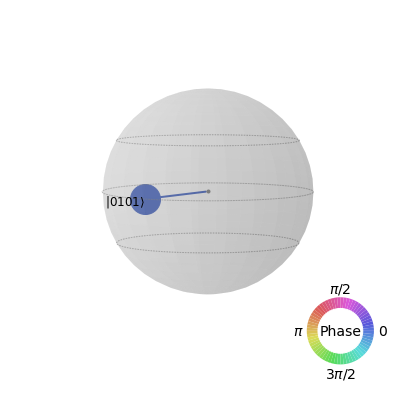

In [ ]:
sv_add = Statevector.from_label('0101')
sv_add = sv_add.evolve(qc)
plot_state_qsphere(sv_add)

### Subtraction

In [ ]:
qa = QuantumRegister(2, 'a')
qb = QuantumRegister(2, 'b')
qc = QuantumCircuit(qa, qb)

sub(qc, qa, qb)
qci = qc.inverse()

qc = qc + qci

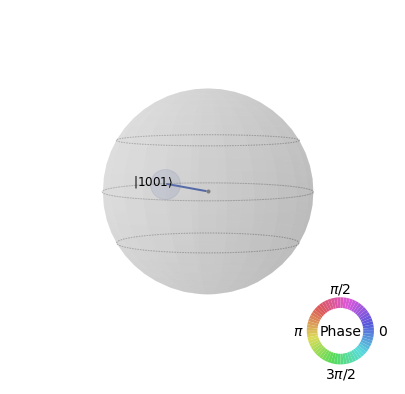

In [ ]:
sv_sub = Statevector.from_label('1001')
sv_sub = sv_sub.evolve(qc)
plot_state_qsphere(sv_sub)

### Multiplication

In [ ]:
qa = QuantumRegister(2, 'a')
qb = QuantumRegister(2, 'b')
qo = QuantumRegister(4, 'o')
qc = QuantumCircuit(qa, qb, qo)

mult(qc, qa, qb, qo)
qci = qc.inverse()

qc = qc + qci

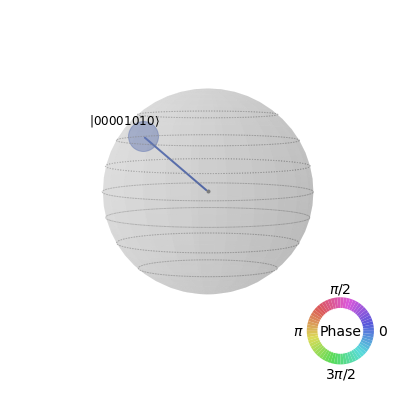

In [ ]:
sv_mul = Statevector.from_label('00001010')
sv_mul = sv_mul.evolve(qc)
plot_state_qsphere(sv_mul)

### Division

In [ ]:
qp = QuantumRegister(4, 'p')
qd = QuantumRegister(4, 'd')
q = QuantumRegister(2, 'q')
qc = QuantumCircuit(qp, qd, q)

div(qc, qp, qd, q)
qci = qc.inverse()

qc = qc + qci

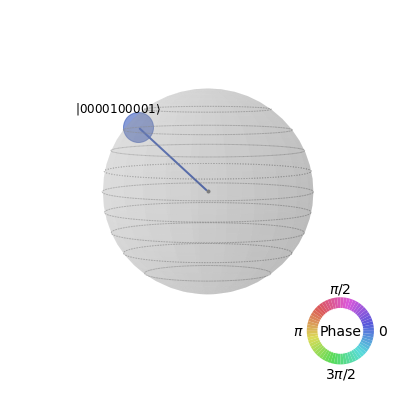

In [ ]:
sv_div = Statevector.from_label('0000100001')
sv_div = sv_div.evolve(qc)
plot_state_qsphere(sv_div)

# Workspace

## Operators

Wrapping up the operations for user interaction

### Addition

In [ ]:
def add_num(a, b):
  bin_a = bin(a)
  bin_b = bin(b)
  m = len(bin_a)
  n = len(bin_b)

  qa = QuantumRegister(m, "input a")
  qb = QuantumRegister(n, "input b")
  c = ClassicalRegister(n, "output")
  qc = QuantumCircuit(qa, qb, c)

  # Creating the initial states
  for i in range(m):
    if bin_a[m - i - 1] == '1':
      qc.x(qa[i])
  for i in range(n):
    if bin_b[n - i - 1] == '1':
      qc.x(qb[i])
  
  # Addition |a>|b> -> |a>|a+b>
  add(qc, qa, qb)

  # Measurement
  qc.measure(qb, c)

  backend = Aer.get_backend('qasm_simulator')
  counts= execute(qc,backend, shots=1024).result().get_counts(qc)
  ans = max(counts, key = counts.get)
  return dec(ans)

### Subtraction

In [ ]:
def sub_num(a, b):
  bin_a = bin(a)
  bin_b = bin(b)
  m = len(bin_a)
  n = len(bin_b)

  qa = QuantumRegister(m, "input a")
  qb = QuantumRegister(n, "input b")
  c = ClassicalRegister(n, "output")
  qc = QuantumCircuit(qa, qb, c)

  # Creating the initial states
  for i in range(m):
    if bin_a[m - i - 1] == '1':
      qc.x(qa[i])
  for i in range(n):
    if bin_b[n - i - 1] == '1':
      qc.x(qb[i])
  
  # Subtraction |a>|b> -> |a>|b-a>
  sub(qc, qa, qb)

  # Measurement
  qc.measure(qb, c)

  backend = Aer.get_backend('qasm_simulator')
  counts= execute(qc,backend, shots=1024).result().get_counts(qc)
  ans = max(counts, key = counts.get)
  return dec(ans)

### Multiplication

In [ ]:
def mul_num(a, b):
  bin_a = bin(a)
  bin_b = bin(b)
  m = len(bin_a)
  n = len(bin_b)
  p = int(np.floor(np.log2(1 + (2 ** n - 1) * (2 ** m - 1))))

  qa = QuantumRegister(m, "input a")
  qb = QuantumRegister(n, "input b")
  qo = QuantumRegister(p, "q output")
  c = ClassicalRegister(p, "c output")
  qc = QuantumCircuit(qa, qb, qo, c)

  # Creating the initial states
  for i in range(m):
    if bin_a[m - i - 1] == '1':
      qc.x(qa[i])
  for i in range(n):
    if bin_b[n - i - 1] == '1':
      qc.x(qb[i])
  
  # Multiplication |a>|b>|0> -> |a>|b>|a*b>
  mult(qc, qa, qb, qo)

  # Measurement
  qc.measure(qo, c)

  backend = Aer.get_backend('qasm_simulator')
  counts= execute(qc,backend, shots=1024).result().get_counts(qc)
  ans = max(counts, key = counts.get)
  return dec(ans)

### Division

In [ ]:
def div_num(a, b):
  bin_a = bin(a)
  bin_b = bin(b)
  bin_a, bin_b = equalizer(bin_a, bin_b)
  n = len(bin_a)

  qa = QuantumRegister(2 * n, "numerator")
  qb = QuantumRegister(2 * n, "denominator")
  q = QuantumRegister(n, "quotient")
  cq = ClassicalRegister(n, "cq")
  cr = ClassicalRegister(n, "cr")
  qc = QuantumCircuit(qa, qb, q, cq, cr)

  # Creating the intitial states
  for i in range(n):
    if bin_a[n - i - 1] == '1':
      qc.x(qa[i])

  for i in range(n):
    if bin_b[n - i - 1] == '1':
      qc.x(qb[n + i])
  
  # Division |a>|b>|0> -> |r>|b>|q>
  div(qc, qa, qb, q)

  # Mesurement
  qc.measure(q, cq)
  qc.measure(qa[n: 2 * n], cr)

  backend = Aer.get_backend('qasm_simulator')
  counts= execute(qc,backend, shots=1024).result().get_counts(qc)
  ans = max(counts, key = counts.get)
  ans_li = ans.split()
  re = dec(ans_li[0])
  qu = dec(ans_li[1])
  return qu, re

## Classical validators

In [ ]:
def add_val(a, b):
  n = len(bin(b))
  return (a + b) % (2 ** n)

In [ ]:
def sub_val(a, b):
  n = len(bin(b))
  return (b - a) % (2 ** n)

In [ ]:
def mul_val(a, b):
  m = len(bin(a))
  n = len(bin(b))
  p = int(np.floor(np.log2(1 + (2 ** n - 1) * (2 ** m - 1))))
  return (a * b) % (2 ** p)

In [ ]:
def div_val(a, b):
  return a // b, a % b

# Qalculator 

In [ ]:
print("-------Qalculator-------")
print()

print("Operations")
print("\t1. Addition ((b+a)mod(2^|b|))")
print("\t2. Subtraction ((b-a)mod(2^|b|))")
print("\t3. Multiplication ((a*b)mod(floor(log2(1+(|a|-1)(|b|-1)))))")
print("\t4. Division (a//b, a%b)")
print()

while True:
  choice = input("Enter choice (1/2/3/4): ")

  if choice in ('1', '2', '3', '4'):
    a = int(input("\tEnter a: "))
    b = int(input("\tEnter b: "))

    print()

    if choice == '1':
      print("\tQalculator: " + str(a) + " + " + str(b) + " = " + str(add_num(a, b)))
      print("\tCalculator: " + str(a) + " + " + str(b) + " = " + str(add_val(a, b)))

    elif choice == '2':
      print("\tQalculator: " + str(b) + " - " + str(a) + " = " + str(sub_num(a, b)))
      print("\tCalculator: " + str(b) + " - " + str(a) + " = " + str(sub_val(a, b)))

    elif choice == '3':
      print("\tQalculator: " + str(a) + " * " + str(b) + " = " + str(mul_num(a, b)))
      print("\tCalculator: " + str(a) + " * " + str(b) + " = " + str(mul_val(a, b)))

    elif choice == '4':
      qu, re = div_num(a, b)
      quc, rec = div_val(a, b)
      print("\tQalculator: " + str(a) + " // " + str(b) + " = " + str(qu) + ", " + str(a) + " % " + str(b) + " = " + str(re))
      print("\tCalculator: " + str(a) + " // " + str(b) + " = " + str(quc) + ", " + str(a) + " % " + str(b) + " = " + str(rec))

    print()

    next = input("Next calculation? (yes/no): ")

    if next != "yes":
      break

    print()

  else:
    print("Invalid Input")
    print()

  print("Operations")
  print("\t1. Addition ((b+a)mod(2^|b|))")
  print("\t2. Subtraction ((b-a)mod(2^|b|))")
  print("\t3. Multiplication (a*b)")
  print("\t4. Division (a//b, a%b)")
  print()
  
print()
print("-------Qalculator-------")

# Workspace (Superposition)

## Operators (Superposition of inputs)

### Addition

In [ ]:
def add_num_s(inputs_a, inputs_b):
  inputs_a = sorted(inputs_a)
  inputs_b = sorted(inputs_b)
  len_a = len(inputs_a)
  len_b = len(inputs_b)
  max_a = len(bin(inputs_a[len(inputs_a) - 1]))
  max_b = len(bin(inputs_a[len(inputs_a) - 1]))
  max_b = int(np.ceil(np.log2((2 ** max_a) + (2 ** max_b) - 2)))

  qa = QuantumRegister(max_a, "a")
  qb = QuantumRegister(max_b, "b")
  c = ClassicalRegister(max_b, "o")
  qc = QuantumCircuit(qa, qb, c)

  # Initialize the states
  li_a = [0] * (2 ** max_a)
  li_b = [0] * (2 ** max_b)
  for i in inputs_a:
    li_a[i] += 1 / len_a
  for i in inputs_b:
    li_b[i] += 1 / len_b
  qc.initialize(np.sqrt(li_a), qa)
  qc.initialize(np.sqrt(li_b), qb)

  # Addition
  add(qc, qa, qb)

  # Measurement
  qc.measure(qb, c)
  backend = Aer.get_backend('qasm_simulator')
  counts= execute(qc,backend, shots=1024).result().get_counts(qc)
  return counts, max_b

### Subtraction

In [ ]:
def sub_num_s(inputs_a, inputs_b):
  inputs_a = sorted(inputs_a)
  inputs_b = sorted(inputs_b)
  len_a = len(inputs_a)
  len_b = len(inputs_b)
  max_a = len(bin(inputs_a[len(inputs_a) - 1]))
  max_b = len(bin(inputs_a[len(inputs_a) - 1]))

  qa = QuantumRegister(max_a, "a")
  qb = QuantumRegister(max_b, "b")
  c = ClassicalRegister(max_b, "o")
  qc = QuantumCircuit(qa, qb, c)

  # Initialize the states
  li_a = [0] * (2 ** max_a)
  li_b = [0] * (2 ** max_b)
  for i in inputs_a:
    li_a[i] += 1 / len_a
  for i in inputs_b:
    li_b[i] += 1 / len_b
  qc.initialize(np.sqrt(li_a), qa)
  qc.initialize(np.sqrt(li_b), qb)

  # Subtraction
  sub(qc, qa, qb)

  # Measurement
  qc.measure(qb, c)
  backend = Aer.get_backend('qasm_simulator')
  counts= execute(qc,backend, shots=1024).result().get_counts(qc)
  return counts, max_b

### Multiplication

In [ ]:
def mul_num_s(inputs_a, inputs_b):
  inputs_a = sorted(inputs_a)
  inputs_b = sorted(inputs_b)
  len_a = len(inputs_a)
  len_b = len(inputs_b)
  max_a = len(bin(inputs_a[len(inputs_a) - 1]))
  max_b = len(bin(inputs_a[len(inputs_a) - 1]))
  len_o = int(np.ceil(np.log2(((2 ** max_a) - 1) * ((2 ** max_b) - 1))))

  qa = QuantumRegister(max_a, "a")
  qb = QuantumRegister(max_b, "b")
  qo = QuantumRegister(len_o, "o_q")
  c = ClassicalRegister(len_o, "o_c")
  qc = QuantumCircuit(qa, qb, qo, c)

  # Initialize the states
  li_a = [0] * (2 ** max_a)
  li_b = [0] * (2 ** max_b)
  for i in inputs_a:
    li_a[i] += 1 / len_a
  for i in inputs_b:
    li_b[i] += 1 / len_b
  qc.initialize(np.sqrt(li_a), qa)
  qc.initialize(np.sqrt(li_b), qb)

  # Multiplication
  mult(qc, qa, qb, qo)

  # Measurement
  qc.measure(qo, c)
  backend = Aer.get_backend('qasm_simulator')
  counts= execute(qc,backend, shots=1024).result().get_counts(qc)
  return counts, len_o

### Division

In [ ]:
def div_num_s(inputs_a, inputs_b):
  inputs_a = sorted(inputs_a)
  inputs_b = sorted(inputs_b)
  len_a = len(inputs_a)
  len_b = len(inputs_b)
  max_a = len(bin(inputs_a[len(inputs_a) - 1]))
  max_b = len(bin(inputs_a[len(inputs_a) - 1]))
  max_len = max(max_a, max_b)

  qa = QuantumRegister(2 * max_len, "a")
  qb = QuantumRegister(2 * max_len, "b")
  q = QuantumRegister(max_len, "q")
  cq = ClassicalRegister(max_len, "o_q")
  cr = ClassicalRegister(max_len, "o_r")
  qc = QuantumCircuit(qa, qb, q, cq, cr)

  # Initialize the states
  li_a = [0] * (2 ** (2 * max_len))
  li_b = [0] * (2 ** (2 * max_len))
  for i in inputs_a:
    li_a[i] += 1 / len_a
  for i in inputs_b:
    li_b[(2 ** max_len) * i] += 1 / len_b
  qc.initialize(np.sqrt(li_a), qa)
  qc.initialize(np.sqrt(li_b), qb)

  # Division
  div(qc, qa, qb, q)

  # Measurement
  qc.measure(q, cq)
  qc.measure(qa[max_len: 2 * max_len], cr)
  backend = Aer.get_backend('qasm_simulator')
  counts= execute(qc,backend, shots=1024).result().get_counts(qc)
  return counts

## Classical validators (Superposition of inputs)

In [ ]:
def add_val_s(inputs_a, inputs_b, n):
  ans_li = []
  for a in inputs_a:
    for b in inputs_b:
      ans_li.append((a + b) % (2 ** n))
  counts = dict()
  for i in ans_li:
    counts[i] = counts.get(i, 0) + 1
  outcomes = list(counts.keys())
  freq = list(counts.values())
  # plt.bar(outcomes, freq)
  plt.bar(range(len(outcomes)), freq)
  plt.xticks(range(len(outcomes)), outcomes)
  plt.show()

In [ ]:
def sub_val_s(inputs_a, inputs_b, n):
  ans_li = []
  for a in inputs_a:
    for b in inputs_b:
      ans_li.append((b - a) % (2 ** n))
  counts = dict()
  for i in ans_li:
    counts[i] = counts.get(i, 0) + 1
  outcomes = list(counts.keys())
  freq = list(counts.values())
  # plt.bar(outcomes, freq)
  plt.bar(range(len(outcomes)), freq)
  plt.xticks(range(len(outcomes)), outcomes)
  plt.show()

In [ ]:
def mul_val_s(inputs_a, inputs_b, n):
  ans_li = []
  for a in inputs_a:
    for b in inputs_b:
      ans_li.append((a * b) % (2 ** n))
  counts = dict()
  for i in ans_li:
    counts[i] = counts.get(i, 0) + 1
  outcomes = list(counts.keys())
  freq = list(counts.values())
  # plt.bar(outcomes, freq)
  plt.bar(range(len(outcomes)), freq)
  plt.xticks(range(len(outcomes)), outcomes)
  plt.show()

In [ ]:
def div_val_s(inputs_a, inputs_b):
  ans_li = []
  for a in inputs_a:
    for b in inputs_b:
      ans_li.append(str(a % b) + " " + str(a // b))
  counts = dict()
  for i in ans_li:
    counts[i] = counts.get(i, 0) + 1
  outcomes = list(counts.keys())
  freq = list(counts.values())
  # plt.bar(outcomes, freq)
  plt.bar(range(len(outcomes)), freq)
  plt.xticks(range(len(outcomes)), outcomes)
  plt.show()

# SQalculator

In [ ]:
print("-------SQalculator-------")
print()

print("Operations")
print("\t1. Addition ((b+a)mod(2^|b|))")
print("\t2. Subtraction ((b-a)mod(2^|b|))")
print("\t3. Multiplication ((a*b)mod(floor(log2(1+(|a|-1)(|b|-1)))))")
print("\t4. Division (a//b, a%b)")
print()

while True:
  choice = input("Enter choice (1/2/3/4): ")

  if choice in ('1', '2', '3', '4'):
    inputs_a_str = input("\tEnter a's (Separate inputs by a single space): ")
    inputs_b_str = input("\tEnter b's (Separate inputs by a single space): ")

    # Process the input
    a_li = inputs_a_str.split(" ")
    b_li = inputs_b_str.split(" ")
    inputs_a = []
    inputs_b = []
    for i in a_li:
      inputs_a.append(int(i))
    for i in b_li:
      inputs_b.append(int(i))
    inputs_a = sorted(inputs_a)
    inputs_b = sorted(inputs_b)

    print()

    if choice == '1':
      c, n = add_num_s(inputs_a, inputs_b)
      c = dict(c)
      print("Quantum result")
      print()
      # plot_histogram(c)
      plt.bar(c.keys(), c.values())
      plt.show()
      print("Classical result")
      print()
      add_val_s(inputs_a, inputs_b, n)

    elif choice == '2':
      c, n = sub_num_s(inputs_a, inputs_b)
      c = dict(c)
      print("Quantum result")
      print()
      plt.bar(c.keys(), c.values())
      plt.show()
      print("Classical result")
      print()
      sub_val_s(inputs_a, inputs_b, n)

    elif choice == '3':
      c, n = mul_num_s(inputs_a, inputs_b)
      c = dict(c)
      print("Quantum result")
      print()
      plt.bar(c.keys(), c.values())
      plt.show()
      print("Classical result")
      print()
      mul_val_s(inputs_a, inputs_b, n)

    elif choice == '4':
      c = div_num_s(inputs_a, inputs_b)
      c = dict(c)
      print("Quantum result")
      print()
      plt.bar(c.keys(), c.values())
      plt.show()
      print("Classical result")
      print()
      div_val_s(inputs_a, inputs_b)

    print()

    next = input("Next calculation? (yes/no): ")

    if next != "yes":
      break

    print()

  else:
    print("Invalid Input")
    print()

  print("Operations")
  print("\t1. Addition ((b+a)mod(2^|b|))")
  print("\t2. Subtraction ((b-a)mod(2^|b|))")
  print("\t3. Multiplication (a*b)")
  print("\t4. Division (a//b, a%b)")
  print()
  
print()
print("-------SQalculator-------")